先import一些library

In [1]:
import datetime
import os
import time
import warnings
import gc
# import presets
import torch
import torch.utils.data
import torchvision
from tmp_modules import utils,transforms

# from coco_utils import get_coco
from torch import nn
from torch.optim.lr_scheduler import PolynomialLR
from torchvision.transforms import functional as F, InterpolationMode
import torchvision.transforms as transforms
try:
    from pytorch_model_summary import summary
except:
    !pip install pytorch-model-summary
    from pytorch_model_summary import summary

try:
    from torchviz import make_dot
except:
    !pip install torchviz
    from torchviz import make_dot

import transformers
try:
    import datasets
except:
    !pip install cchardet
    !pip install datasets
    import datasets
    
# from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from IPython.display import clear_output, display

c:\Users\user\anaconda3\envs\trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


先定義一些function

In [2]:
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]

def evaluate(model, data_loader, device, num_classes):
    model.eval()
    model.to(device)

    # confmat = utils.ConfusionMatrix(num_classes)
    # metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"
    num_processed_samples = 0
    total_loss            = 0
    with torch.inference_mode():
        for image, target in data_loader: #metric_logger.log_every(data_loader, len(data_loader), header):
            image, target = image.to(device), target.to(device)
###
            target = target.squeeze(1)
# Convert target to Long type
            target = target.type(torch.LongTensor).to(device)
            
            output = model(image)
            loss = criterion(output, target)
            total_loss += loss.item()
            # output = output["out"]
            # confmat.update(target.flatten(), output.argmax(1).flatten())
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            num_processed_samples += image.shape[0]
            
            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()

        # confmat.reduce_from_all_processes()

    # num_processed_samples = utils.reduce_across_processes(num_processed_samples)
    # if (
    #     hasattr(data_loader.dataset, "__len__")
    #     and len(data_loader.dataset) != num_processed_samples
    #     and torch.distributed.get_rank() == 0
    # ):
    #     # See FIXME above
    #     warnings.warn(
    #         f"It looks like the dataset has {len(data_loader.dataset)} samples, but {num_processed_samples} "
    #         "samples were used for the validation, which might bias the results. "
    #         "Try adjusting the batch size and / or the world size. "
    #         "Setting the world size to 1 is always a safe bet."
    #     )

    # return confmat
    return total_loss/ num_processed_samples
'''
def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, run_device, epoch, pbar, scaler=None):
    cpu_device = torch.device('cpu')
    device     = run_device
    model.train()
    model.to(device)
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value}"))
    # header = f"Epoch: [{epoch}]"
    
    error_count   = 0
    training_loss = []
    for idx, (image, target) in enumerate(data_loader): #metric_logger.log_every(data_loader, print_freq, header):
        # print(image.shape,image.dtype,target.shape)
        try:
            
            image, target = image.to(device), target.to(device)
            print('try: *****************idx: ', idx)
            

            with torch.cuda.amp.autocast(enabled=scaler is not None):
                output = model(image)
                predicted_classes = torch.argmax(output, dim=1)
                print('!!!!!!!!!!!')
                print(predicted_classes)
                loss = criterion(output, target)

            
            ###
            target = target.squeeze(1)
            # Convert target to Long type
            target = target.type(torch.LongTensor).to(device)

            print('!!!!!!!!!!!')
            print(image.shape)
            output = model(image)
            #predicted_classes = torch.argmax(output, dim=1)
            #print(predicted_classes)
            loss = criterion(output, target)
            print('output: ', output.numpy())
            print('target: ', target)
            print('loss: ', loss)
            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            if lr_scheduler is not None:
                lr_scheduler.step()

            pbar.update(idx, values=[("loss",loss.item())])

            # metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"], mem=torch.cuda.memory_allocated(device))
            training_loss.append(loss.item())

            del image, target, output, loss

            gc.collect()
            torch.cuda.empty_cache()
        except:
            print('except: *************')
            error_count += 1
            if error_count < 10:
                model.to(cpu_device)
                gc.collect()
                torch.cuda.empty_cache()
                model.to(device)
                model.train()
            else:
                raise RuntimeError('GPU out of memory error')
            
            print('training_loss', training_loss)
            print('np.array(training_loss)', np.array(training_loss))
            print('np.mean(np.array(training_loss))', np.mean(np.array(training_loss)))
            
    return np.mean(np.array(training_loss))
'''
def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, print_freq, scaler=None):
    model.train()
    training_loss = []

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value}"))
    header = f"Epoch: [{epoch}]"
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image.to(device), target.to(device)

        ###
        target = target.squeeze(1)
        # Convert target to Long type
        target = target.type(torch.LongTensor).to(device)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            output = model(image)
            loss = criterion(output, target)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        training_loss.append(loss.item())
    return np.mean(np.array(training_loss))

def train(model, epochs, data_loader, data_loader_valid, early_stop=0, model_pathname=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(torch.cuda.get_device_name(0))
    print(device)
    gc.collect()
    torch.cuda.empty_cache()

    model.to(device)
    if hasattr(model,'backbone'):
        params_to_optimize = [
            {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
            {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
        ]
    else:
        params_to_optimize = [{ "params": model.parameters() }]

    optimizer = torch.optim.Adam(params_to_optimize)
    scaler = None #torch.cuda.amp.GradScaler()
    iters_per_epoch = len(data_loader)
    lr_scheduler    = None # PolynomialLR(optimizer, total_iters=iters_per_epoch * epochs, power=0.9)
    training_loss   = []
    val_loss        = []
    min_val_loss    = np.inf
    min_val_epoch   = 0
    start_time = time.time()

    n_batch = len(data_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch,stateful_metrics=['val_loss'])

    for epoch in range(epochs):
        
        print(f'Epoch {epoch+1}/{epochs}')

        tr_loss = train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, 10, scaler)
        print(tr_loss)
        training_loss.append(tr_loss)

        if data_loader_valid is not None:
            v_loss = evaluate(model, data_loader_valid, device=device, num_classes=num_classes)
            val_loss.append(v_loss)
            pbar.update(n_batch, values=[('val_loss', v_loss)])

            # save the parameters with the least loss
            if v_loss < min_val_loss:
                min_val_loss = v_loss
                min_val_epoch= epoch
                if model_pathname is not None:
                    torch.save(model.state_dict(),model_pathname)

            # early stop
            if early_stop > 0 and epoch - min_val_epoch >= early_stop:
                break

        # confmat = evaluate(model, data_loader_valid, device=device, num_classes=num_classes)
        # print(confmat)
        if lr_scheduler is not None:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "lr_scheduler": lr_scheduler.state_dict(),
                "epoch": epoch,
            } 
        else:
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
            } 
        # utils.save_on_master(checkpoint, os.path.join('.', f"model_{epoch}.pth"))
        # utils.save_on_master(checkpoint, os.path.join('.', "checkpoint.pth"))

    if data_loader_valid is not None and model_pathname is not None:
        model.load_state_dict(torch.load(model_pathname))

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"Training time {total_time_str}")
    return {'loss':training_loss,'val_loss':val_loss}

def showSegmentationResult(model,dataset):
    plt.figure(figsize=(6,6))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for i, idx in enumerate([0, len(dataset)//2, len(dataset)-1]):
        img, target = dataset[idx]
        outputs = model(torch.unsqueeze(img,0).to(device))   
        labels  = torch.squeeze(torch.argmax(outputs['out'].cpu(),dim=1)).numpy()
        plt.subplot(3,3,i*3+1)
        
        plt.imshow(np.transpose(torch.squeeze(img).cpu().numpy(),(1,2,0)))
        plt.axis(False)

        plt.subplot(3,3,i*3+2)
        plt.imshow(target)
        plt.axis(False)

        plt.subplot(3,3,i*3+3)
        plt.imshow(labels)
        plt.axis(False)

    plt.show()
    return

準備資料集

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SplashDataSet(Dataset):
    def __init__(self, data_dir, train, transform=None):
        # check for training or validation
        if train:
            split = 'training'
        else:
            split = 'validation'
        # get the directory path
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, 'images', split)
        self.annotations_dir = os.path.join(data_dir, 'annotations', split)
        # check the number of image and mask in two directory: images and annotations
        self.images_list = os.listdir(self.images_dir)
        self.annotations_list = os.listdir(self.annotations_dir)
        assert len(self.images_list) == len(self.annotations_list), "Number of images and annotations should be the same."
        
        self.transform = transform
    def __len__(self):
        return len(self.images_list)
    def __getitem__(self, idx):
        # 讀取原圖
        img_name = os.path.join(self.images_dir, self.images_list[idx])
        image = Image.open(img_name)

        # 讀取遮罩
        mask_name = os.path.join(self.annotations_dir, self.annotations_list[idx])
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # 因為只有一個類別，將 mask 轉換成二元的 0 和 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        return image, mask

dataloader

In [4]:
from torch.utils.data import DataLoader
import tkinter as tk
from tkinter import filedialog

# transform the image
transform = transforms.Compose([
    # transforms.Resize((256, 256)),
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

#########################################################################

# Choose Directory
data_folder = select_folder()
print(data_folder)

# create SplashDataSet
dataset = SplashDataSet(data_dir=data_folder, train=True, transform=transform)
dataset_val = SplashDataSet(data_dir=data_folder, train=False, transform=transform)

# use DataLoader to load data in batch_size
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True)

C:/Users/user/Desktop/data/output_frames


檢查能不能讀到資料夾中的影像

image type =  torch.FloatTensor
image shape =  torch.Size([3, 480, 640])
tensor([[[0.7647, 0.7686, 0.7686,  ..., 0.4196, 0.4235, 0.4235],
         [0.7647, 0.7686, 0.7686,  ..., 0.4196, 0.4235, 0.4235],
         [0.7647, 0.7686, 0.7686,  ..., 0.4235, 0.4235, 0.4235],
         ...,
         [0.3373, 0.3373, 0.3412,  ..., 0.4118, 0.4118, 0.4118],
         [0.3412, 0.3412, 0.3451,  ..., 0.4196, 0.4196, 0.4196],
         [0.3647, 0.3647, 0.3686,  ..., 0.4392, 0.4392, 0.4392]],

        [[0.8039, 0.8078, 0.8078,  ..., 0.4784, 0.4784, 0.4745],
         [0.8039, 0.8078, 0.8078,  ..., 0.4784, 0.4784, 0.4745],
         [0.8039, 0.8078, 0.8078,  ..., 0.4824, 0.4784, 0.4745],
         ...,
         [0.3608, 0.3608, 0.3647,  ..., 0.4275, 0.4275, 0.4275],
         [0.3647, 0.3647, 0.3686,  ..., 0.4314, 0.4314, 0.4314],
         [0.3882, 0.3882, 0.3922,  ..., 0.4549, 0.4549, 0.4549]],

        [[0.8353, 0.8392, 0.8392,  ..., 0.5373, 0.5647, 0.5804],
         [0.8353, 0.8392, 0.8392,  ..., 0.5373, 0.

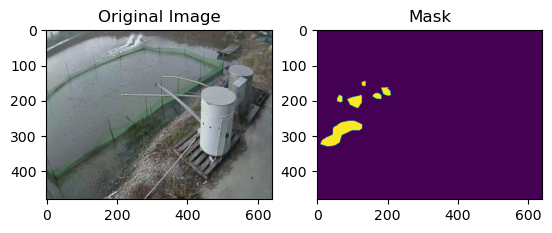

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 選擇要印出的資料的編號
data_index = 15

# 取得指定編號的資料
image, mask = dataset[data_index]

print('image type = ', image.type())
print('image shape = ', image.shape)
print(image)
# 將 PyTorch 張量轉換為 NumPy 陣列
image = image.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).numpy()
print('*************')
print('image shape = ', image.shape)
print(image)
# 顯示原圖
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

# 顯示遮罩
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')

plt.show()


定義FCN-ResNet50

In [6]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

num_classes = 2

fcn_resnet50_model = torchvision.models.get_model(
        'fcn_resnet50',
        weights_backbone='ResNet50_Weights.IMAGENET1K_V1',
        num_classes=num_classes)

print(summary(fcn_resnet50_model, torch.zeros((1, 3, 480, 640)), show_input=True, show_parent_layers=True, max_depth=1)) 

---------------------------------------------------------------------------------------------------
   Parent Layers                 Layer (type)           Input Shape         Param #     Tr. Param #
             FCN    IntermediateLayerGetter-1      [1, 3, 480, 640]      23,508,032      23,508,032
             FCN                     Conv2d-2     [1, 2048, 60, 80]       9,437,184       9,437,184
             FCN                BatchNorm2d-3      [1, 512, 60, 80]           1,024           1,024
             FCN                       ReLU-4      [1, 512, 60, 80]               0               0
             FCN                    Dropout-5      [1, 512, 60, 80]               0               0
             FCN                     Conv2d-6      [1, 512, 60, 80]           1,026           1,026
Total params: 32,947,266
Trainable params: 32,947,266
Non-trainable params: 0
---------------------------------------------------------------------------------------------------


訓練

In [7]:
lc = train(fcn_resnet50_model,10,dataloader,dataloader_val)

NVIDIA GeForce RTX 4090
cuda
Epoch 1/10
Epoch: [0]  [0/8]  eta: 0:00:16  lr: 0.001  loss: 0.7175 (0.7175)  time: 2.0876  data: 0.1060  max mem: 3824
Epoch: [0] Total time: 0:00:03
0.7984553966671228
8/8 [==============================] - 5s 574ms/step - val_loss: 0.3352
Epoch 2/10
Epoch: [1]  [0/8]  eta: 0:00:01  lr: 0.001  loss: 0.1685 (0.1685)  time: 0.2363  data: 0.1046  max mem: 4078
Epoch: [1] Total time: 0:00:01
0.11535627488046885
8/8 [==============================] - 7s 906ms/step - val_loss: 0.2765
Epoch 3/10
Epoch: [2]  [0/8]  eta: 0:00:01  lr: 0.001  loss: 0.0805 (0.0805)  time: 0.2357  data: 0.1107  max mem: 4078
Epoch: [2] Total time: 0:00:01
0.05436253733932972
8/8 [==============================] - 10s 1s/step - val_loss: 0.1366  
Epoch 4/10
Epoch: [3]  [0/8]  eta: 0:00:01  lr: 0.001  loss: 0.0513 (0.0513)  time: 0.2433  data: 0.1085  max mem: 4078
Epoch: [3] Total time: 0:00:01
0.041189949959516525
8/8 [==============================] - 13s 2s/step - val_loss: 0.1655
E

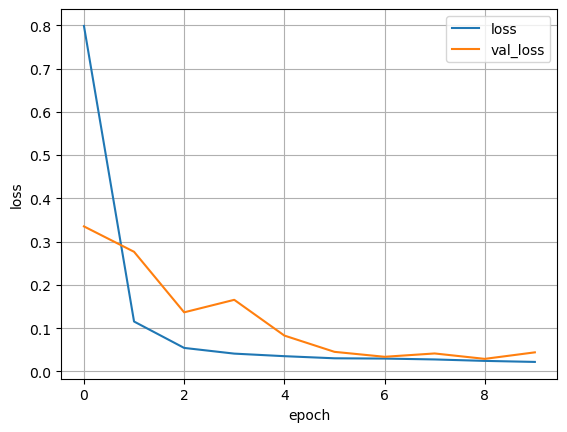

In [8]:
plt.figure()
plt.plot(lc['loss'],label='loss')
plt.plot(lc['val_loss'],label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()